# AvaStats

## Preparation I - Fetch Data

Download the required Data - **Download only what you need!** (Download Reports from Euregio-Albina and Tyrol Archive)
The downloaded data is cached in /data/bulletins. So if the up-to-date data is already updated, this step has not to be repeated.

In [1]:
import os
from pathlib import Path
from avastats.helpers import download_from_index

# ------------------------------------ #
# Switches - Configure download here!
tyrol_archive = False

albina_euregio = True
albina_euregio_restrict = True
albina_euregio_restrict_start = "2021-12-01" # as string with YYYY-MM-DD
albina_euregio_restrict_end  = "2022-04-30" # as string with YYYY-MM-DD

eaws = False
albina_neighbors = False # Not yet productive, old format!
# ------------------------------------ #

local_dir = os.getcwd() + "/data/bulletins"
local_dir_eaws = os.getcwd() + "/data/eaws_bulletins"
directory = Path(local_dir)
directory.mkdir(parents=True, exist_ok=True)

if tyrol_archive:
    download_from_index(
        url="https://static.avalanche.report/bulletins/archive/tyrol/caaml/",
        local_dir=local_dir,
        details="tyrol_archive"
    )

if eaws:
    download_from_index(
        url="https://static.avalanche.report/eaws_bulletins/",
        local_dir=local_dir_eaws,
        details="albina_euregio_restrict",
        start=albina_euregio_restrict_start,
        end=albina_euregio_restrict_end
    )    
            
if albina_euregio:
    if albina_euregio_restrict:
        download_from_index(
            url="https://static.avalanche.report/bulletins/",
            local_dir=local_dir,
            details="albina_euregio_restrict",
            start=albina_euregio_restrict_start,
            end=albina_euregio_restrict_end
        )
    else:
        download_from_index(
            url="https://static.avalanche.report/bulletins/",
            local_dir=local_dir,
            details="albina_euregio"
        )

### Preparation II: Install Packages from Subfolder/Subprojects

It may be a good idea to update the submodules sometimes. But it is also possible, that a breaking change in the submodules could also break the code below.

To initiate git submodules (first time) use:
- `git submodule init`

To install the Submodules use:
- `git submodule update`

Current tested Versions:

- pyAvaCore: Commit SHA e25c7bbc793a208c3c70ef3211cf4e0b169281d8

Then Install pyAvaCore with the line below:

In [2]:
# !{sys.executable} -m pip install -e pyAvaCore
# Alternatively run this command within avastats in the Terminal to install pyAvaCore

### Preparation III: Load DangerLevel-Dataset

Is required for some processing-steps (requirement mentioned)

In [9]:
import datetime
from avastats.avacore_connector import AvacoreConnector
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

# ------------------------------------ #
# Switches
start = datetime.date(2021,12,2) #"2021-10-01" # as string with YYYY-MM-DD
end   = datetime.date(2022,4,29) #"2022-04-24" # as string with YYYY-MM-DD
regions_of_interest = ['AT-07','IT-32-BZ','IT-32-TN'] 
# regions_of_interest = ['AT-7'] # ['AT7'] # Euregio_regions are possible, e. g. ['AT-07', 'IT-32-BZ'] and AT7 for tyrolian archive

prefix_dict = {
    "AT-07": "EUREGIO",
    "AT7": "TYROL",
    "IT-32-BZ": "EUREGIO",
    "IT-32-TN": "EUREGIO",
    "IT-32":'ITALIA'
}
# ------------------------------------ #

connector =  AvacoreConnector()
macro_regions = connector.get_macro_regions()

day_range = pd.date_range(start=start,end=end).to_pydatetime().tolist()

d_max              = []
d_morning          = []
d_afternoon        = []
micro_regions_axes = []

for macro_id in regions_of_interest:
    d_max_n, d_morning_n, d_afternoon_n, micro_regions_axes_n = connector.get_dangerlevels_for_region(macro_id, day_range, macro_filename=prefix_dict[macro_id])
    d_max.append(d_max_n)
    d_morning.append(d_morning_n)
    d_afternoon.append(d_afternoon_n)
    micro_regions_axes.append(micro_regions_axes_n)

micro_regions_axes = np.concatenate(micro_regions_axes)
df_d_max           = pd.DataFrame(data=np.concatenate(d_max), index=micro_regions_axes)
df_d_morning       = pd.DataFrame(data=np.concatenate(d_morning), index=micro_regions_axes)
df_d_afternoon     = pd.DataFrame(data=np.concatenate(d_afternoon), index=micro_regions_axes)

df_max = df_d_max.max().to_frame()
n_days = len(df_max) # Make sure season fits or consider np.nan for -1 and only count days with values
df_max.columns = ['count']
df_max = df_max['count'].value_counts(sort=False).reset_index() # index hold 'danger level'
df_max.replace(to_replace=[None, -1], value=np.nan, inplace=True)

# - Optional in case no days with danger level 5 - #
df_max.loc[5] = [5,0]

# - Sort for index - #
df_max = df_max.set_index('index')
df_max = df_max.sort_index()
df_max['freq'] = df_max['count']/ n_days * 100

# TODO
# Calculate frequencies only using timestamps with ava report -> nan days should not be considered...
# Drop nan indexes for further analysis

df_max

count       freq
index                  
1         19  12.751678
2         62  41.610738
3         55  36.912752
4         13   8.724832
5          0   0.000000

# Processing

## 1. Danger Level Histogram

**Preparation III has to be run first**

Works only for EUREGIO at the Moment

In [10]:
plt.style.use('latex_default.mplstyle')
color_palette = ['#ccff66','#ffff00','#ff9900','#ff0000','black']

# - Add bars for 10-year alp average - #
ALPS_DANGER_LEVELS = [19,42,37,2.2,0.1]
df_avg = df_max.copy()
df_avg.loc[:,'freq'] = ALPS_DANGER_LEVELS

label = {"x": "Highest danger level per day", "y": "Frequency / %"}
# label = {"x": "Gefahrenstufe", "y": "Frequenz"}
# label = {"x": "Scala di pericolo", "y": "Frequenza"}

fig, ax = plt.subplots(figsize=(6,6)) 
ax.grid(False)
ax.grid(axis='y')
ax.bar(df_avg.index+0.2,df_avg['freq'],width=0.67,color='lightgrey',align='center',alpha=0.67, label='10-year average (Alps)')
ax.bar(df_max.index,df_max['freq'],width=0.67,color=color_palette, edgecolor='black',align='center') # bottom=df['bottom'], alpha=0.4
# ax.set_xticklabels(['1','2','3','4','5'])
plt.xlabel(label["x"],fontsize=15)
plt.ylabel(label["y"],fontsize=15)
ax.legend()

# Save Plot to File
filename = "dangerLevel-histogram"
out_dir = "output"
directory = Path(out_dir)
directory.mkdir(parents=True, exist_ok=True)

plt.savefig(f'{out_dir}/{filename}.pdf')
plt.savefig(f'{out_dir}/{filename}.png')

plt.show()

## 2. Maximum danger levels over time (season)


In [1]:
import datetime
from avastats.avacore_connector import AvacoreConnector
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import AutoMinorLocator, FuncFormatter

from pathlib import Path
# ------------------------------------ #
# Switches - Configure download here!
start = datetime.date(2021,12,2) #"2021-10-01" # as string with YYYY-MM-DD
end   = datetime.date(2022,4,29) #"2022-04-24" # as string with YYYY-MM-DD
regions_of_interest = ['AT-07','IT-32-BZ','IT-32-TN'] 
# regions_of_interest = ['AT-7'] # ['AT7'] # Euregio_regions are possible, e. g. ['AT-07', 'IT-32-BZ'] and AT7 for tyrolian archive

prefix_dict = {
    "AT-07": "EUREGIO",
    "AT7": "TYROL",
    "IT-32-BZ": "EUREGIO",
    "IT-32-TN": "EUREGIO",
    "IT-32":'ITALIA'
}
# ------------------------------------ #

connector =  AvacoreConnector()
macro_regions = connector.get_macro_regions()

day_range = pd.date_range(start=start,end=end).to_pydatetime().tolist()

d_max              = []
d_morning          = []
d_afternoon        = []
micro_regions_axes = []

for macro_id in regions_of_interest:
    d_max_n, d_morning_n, d_afternoon_n, micro_regions_axes_n = connector.get_dangerlevels_for_region(macro_id, day_range, macro_filename=prefix_dict[macro_id])
    d_max.append(d_max_n)
    d_morning.append(d_morning_n)
    d_afternoon.append(d_afternoon_n)
    micro_regions_axes.append(micro_regions_axes_n)

micro_regions_axes = np.concatenate(micro_regions_axes)
df_d_max           = pd.DataFrame(data=np.concatenate(d_max), index=micro_regions_axes)
df_d_morning       = pd.DataFrame(data=np.concatenate(d_morning), index=micro_regions_axes)
df_d_afternoon     = pd.DataFrame(data=np.concatenate(d_afternoon), index=micro_regions_axes)

# - Calculate percentage for every day of season - #
danger_levels = [0,0,0,0,0]
days = np.arange(np.shape(df_d_max)[1])
freq_dict = {}
for day in days:
    freq_dict[day]=danger_levels
df_freq = pd.DataFrame.from_dict(freq_dict)
# df_freq = df_freq.set_index()

for col in range(np.shape(df_d_max)[1]):
    df_freq.loc[0,col] = (df_d_max[col] == 1).sum()
    df_freq.loc[1,col] = (df_d_max[col] == 2).sum()
    df_freq.loc[2,col] = (df_d_max[col] == 3).sum()
    df_freq.loc[3,col] = (df_d_max[col] == 4).sum()
    df_freq.loc[4,col] = (df_d_max[col] == 5).sum()
n_regions = np.shape(df_d_max)[0]
df_freq = df_freq / n_regions * 100

# - Preparation for bar plot - #
df_freq_cum=df_freq.cumsum()
i=np.arange(1,5)
df_freq_cum.loc[i]=df_freq_cum.loc[i-1].values
df_freq_cum.loc[0,:] = 0
df_freq_cum=df_freq_cum.T
df_freq=df_freq.T

# TODO get date for timestamps
# df_freq

In [2]:
# - VISUALIZATION - #
plt.style.use('latex_default.mplstyle')

COLS_DANGER_LEVELS = ['#ccff66','#ffff00','#ff9900','#ff0000','black']
DANGERLEVS_NAMES = [ "Low", "Moderate", "Considerable", "High", "Very High"]
COL_INDEXES   = np.arange(0,6)
col_dict = dict(zip(COL_INDEXES,COLS_DANGER_LEVELS[::-1]))
cmap = ListedColormap([col_dict[x] for x in col_dict.keys()])


fig, ax = plt.subplots(1,1,figsize=(12,6))
# w=df_danger_patterns.index[1]-df_danger_patterns.index[0]
w=1
for i in range(len(df_freq)):
    bar_plot = ax.bar(day_range[i], df_freq.loc[i], bottom=df_freq_cum.loc[i], width=w, align='edge', color=COLS_DANGER_LEVELS)
    # bar_plot = ax.bar(df_freq.index[i], df_freq.loc[i], bottom=df_freq_cum.loc[i], width=w, align='edge', color=COLS_DANGER_LEVELS)

# - COLORBAR (Norm, bins, formatter, ticks) ** lots of stuff to make colorbar look nice - #
n_bar = len(COLS_DANGER_LEVELS)
lulu = np.zeros((n_bar,n_bar))
for nn,k in enumerate(col_dict.keys()):
    lulu[nn, :] = k
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

norm = BoundaryNorm(norm_bins, n_bar, clip=True)
fmt = FuncFormatter(lambda x, pos: DANGERLEVS_NAMES[::-1][norm(x)])
diff = norm_bins[1:] - norm_bins[:-1] 
tickz = norm_bins[:-1] + diff / 2

contf = ax.contourf(lulu,cmap=cmap,norm=norm,levels=norm_bins) # just for colorbar
# contf = ax.contourf(lulu,cmap=cmap,norm=norm,levels=norm_bins,hatch=HATCHES_GRAIN_TYPE_BAR) # just for colorbar
cbar = fig.colorbar(contf, format=fmt, ticks=tickz,location='left', pad=0.02) # shrink=0.7, ax=[axes[1],axes[3], axes[5]]

# - AXES - # day_range
ax.set_xlim(day_range[0],day_range[-1])
# ax.set_xlim(df_avaProbs.index[0],df_avaProbs.index[-1])
# ax.set_ylim(0,100)

ax.grid(axis='x')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("Regions affected / %")

myLoc = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%y-%b-%d') # %Y-%b-%d
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(myLoc)
ax.yaxis.set_minor_locator(AutoMinorLocator())

# - Include Meta data in top left corner and save figure - #
# header_str = meta_dict['StationName'] + '\nAltitude: ' + meta_dict['Altitude'] + \
#             'm\nSlope Angle: ' + str(int(float(meta_dict['SlopeAngle']))) + '°\nExposure: ' + str(int(float(meta_dict['SlopeAzi'])))  + '°'
# fig.text(0.17,0.94,header_str,horizontalalignment='left',
#          verticalalignment='top', fontsize=10) # ma='left'

# --- Save figure --- #
filename  = 'dangerLevels-over-season'
out_dir   = "output"
directory = Path(out_dir)
directory.mkdir(parents=True, exist_ok=True)
fig.tight_layout()
fig.savefig(f'{out_dir}/{filename}.png', facecolor='w', edgecolor='w',
            format='png', dpi=300)

## 3. Avalanche Problems over time

In [20]:
import xml.etree.ElementTree as ET
import os
from pyAvaCore.avacore.avabulletins import Bulletins
from pyAvaCore.avacore import pyAvaCore
# from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import AutoMinorLocator, FuncFormatter
import pandas as pd
import numpy as np
import datetime
from pathlib import Path

def check_regions_of_interest(x):
    # for region in x:
    for region in regions_of_interest:
        if x.startswith(region):
            return True
    return False

# ------------------------------------ #
start_season = "2021-12-01" # as string with YYYY-MM-DD
end_season   = "2022-04-30" # as string with YYYY-MM-DD

regions_of_interest = ['AT-07'] # Euregio_regions are possible, e. g. ['AT-07', 'IT-32-BZ']
# ------------------------------------ #

In [21]:
local_dir = os.getcwd() + "/data/bulletins"
avaProbs = [ "new_snow", "wind_drifted_snow", "persistent_weak_layers", "wet_snow", "gliding_snow", "cornice_failure"]
# ava_problems = [ "new_snow", "wind_drifted_snow", "persistent_weak_layers", "wet_snow", "gliding_snow", "cornice_failure", "favourable_situation" ]

day_range = pd.date_range(start=start_season,end=end_season).to_pydatetime().tolist()
day_range = [d.date() for d in day_range]
df_avaProbs = pd.DataFrame(0, index=np.arange(len(avaProbs)), columns=day_range)

for file in os.listdir(local_dir):
    if "EUREGIO" in file:
        bulletins = Bulletins()
        with open(local_dir + '/' + file) as fp:
            # clear_output(wait=True)
            # print(file)
            if ".xml" in file:
                root = ET.parse(fp)
                bulletins.bulletins = pyAvaCore.parse_xml(root)
            if ".json" in file:
                data = json.load(fp)
                try:
                    bulletins.from_json(data)
                except:
                    print("Can't work with JSON file:", file)
        date = bulletins.main_date()
        if date < datetime.datetime.strptime(end_season, "%Y-%m-%d").date() and date > datetime.datetime.strptime(start_season, "%Y-%m-%d").date():
            no_regions = 0.
            ### print(no_regions)
            i=0
            for bulletin in bulletins.bulletins:
                ### print(bulletin.get_region_list())
                bulletin_no_regions = sum(check_regions_of_interest(x) for x in bulletin.get_region_list())
                no_regions += bulletin_no_regions
                ### print(i,no_regions)
                # if bulletin.avalancheProblems:
                ns = []
                for avaProb in bulletin.avalancheProblems:
                    n = avaProbs.index(avaProb.problemType)
                    if n in ns:
                        pass # cover early, later, ... bulletin
                    else:
                        # print(i,avaProb.problemType,avaProb.validTimePeriod)
                        ns.append(n)
                        df_avaProbs.loc[n, date] += bulletin_no_regions
                i+=1
                
            for avaProb in avaProbs:
                n = avaProbs.index(avaProb)
                df_avaProbs.loc[n, date] = 100 * df_avaProbs.loc[n, date] / no_regions
                # df_avaProbs.loc[n, date] = 100 * df_avaProbs.loc[n, date] / 58

df_avaProbs_cum=df_avaProbs.cumsum()
i=np.arange(1,len(avaProbs))
df_avaProbs_cum.loc[i]=df_avaProbs_cum.loc[i-1].values
df_avaProbs_cum.loc[0,:] = 0
df_avaProbs_cum=df_avaProbs_cum.T
df_avaProbs=df_avaProbs.T
# df_avaProbs

/var/folders/5n/r616r2rx3710m3kyf90_xwdr0000gn/T/ipykernel_47641/2491134302.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,50,100])


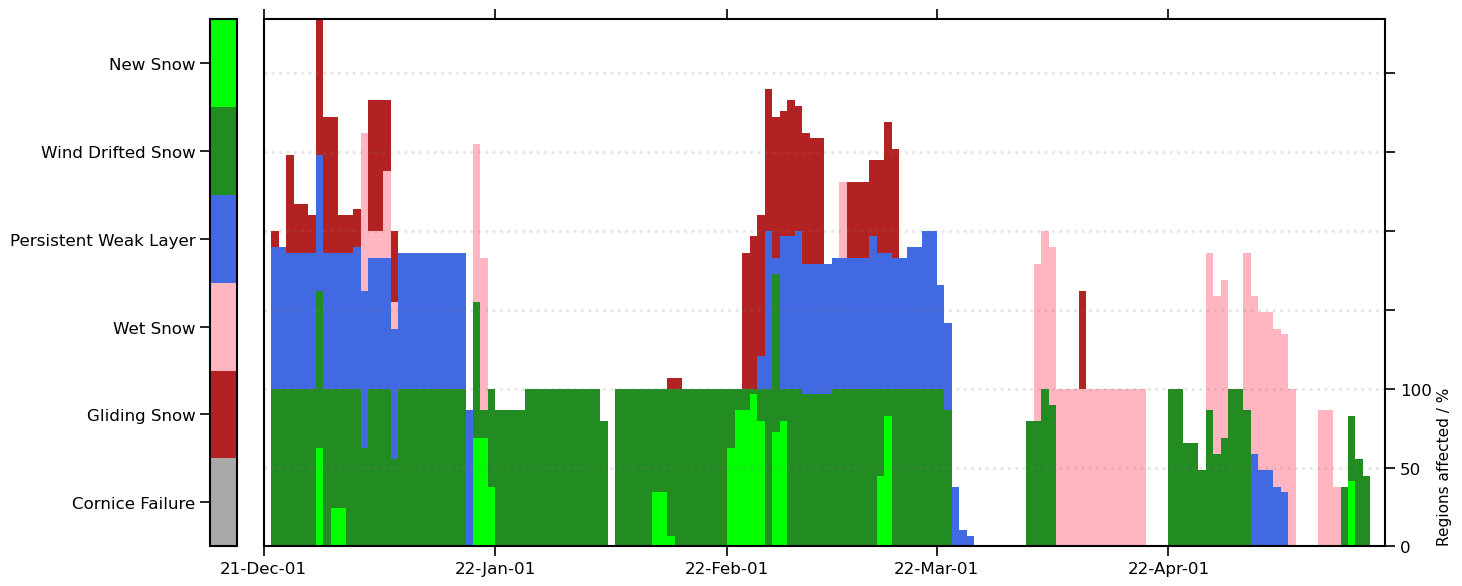

In [22]:
# - VISUALIZATION - #
plt.style.use('latex_default.mplstyle')

AVAPROBS_NAMES = [ "New Snow", "Wind Drifted Snow", "Persistent Weak Layer", "Wet Snow", "Gliding Snow", "Cornice Failure"]
COLS_AVAPROBS = ['lime','forestgreen','royalblue','lightpink','firebrick','darkgray']
COL_INDEXES   = np.arange(0,6)
col_dict = dict(zip(COL_INDEXES,COLS_AVAPROBS[::-1]))
cmap = ListedColormap([col_dict[x] for x in col_dict.keys()])

data = df_avaProbs.to_numpy()

fig, ax = plt.subplots(1,1,figsize=(15,6))
w=df_avaProbs.index[1]-df_avaProbs.index[0]
for i in range(len(df_avaProbs)):
    bar_plot = ax.bar(df_avaProbs.index[i], df_avaProbs.loc[df_avaProbs.index[i]], bottom=df_avaProbs_cum.loc[df_avaProbs.index[i]], width=w, align='edge', color=COLS_AVAPROBS)
# bar_plot = ax.bar(df_danger_patterns.index, df_danger_patterns, width=0.1, align='edge', color=COLS_PATTERN) #  alpha=a, label=labels[i])

# - COLORBAR (Norm, bins, formatter, ticks) ** lots of stuff to make colorbar look nice - #
n_bar = len(COLS_AVAPROBS)
lulu = np.zeros((n_bar,n_bar))
for nn,k in enumerate(col_dict.keys()):
    lulu[nn, :] = k
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

norm = BoundaryNorm(norm_bins, n_bar, clip=True)
fmt = FuncFormatter(lambda x, pos: AVAPROBS_NAMES[::-1][norm(x)])
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2

contf = ax.contourf(lulu,cmap=cmap,norm=norm,levels=norm_bins) # just for colorbar
# contf = ax.contourf(lulu,cmap=cmap,norm=norm,levels=norm_bins,hatch=HATCHES_GRAIN_TYPE_BAR) # just for colorbar
cbar = fig.colorbar(contf, format=fmt, ticks=tickz,location='left', pad=0.02) # shrink=0.7, ax=[axes[1],axes[3], axes[5]]

# - AXES - # 
ax.set_xlim(df_avaProbs.index[0],df_avaProbs.index[-1])
# ax.set_ylim(0,100)

ax.grid(axis='x')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ylabel_str = "Regions affected / %                                                                           "
ax.set_ylabel(ylabel_str, size=11)

myLoc = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%y-%b-%d') # %Y-%b-%d
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(myLoc)
# ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_yticklabels([0,50,100])

# - Include Meta data in top left corner and save figure - #
# header_str = meta_dict['StationName'] + '\nAltitude: ' + meta_dict['Altitude'] + \
#             'm\nSlope Angle: ' + str(int(float(meta_dict['SlopeAngle']))) + '°\nExposure: ' + str(int(float(meta_dict['SlopeAzi'])))  + '°'
# fig.text(0.17,0.94,header_str,horizontalalignment='left',
#          verticalalignment='top', fontsize=10) # ma='left'

# --- Save figure --- #
filename  = 'avaProblems-over-season'
out_dir   = "output"
directory = Path(out_dir)
directory.mkdir(parents=True, exist_ok=True)
fig.tight_layout()
fig.savefig(f'{out_dir}/{filename}.png', facecolor='w', edgecolor='w',
            format='png', dpi=300)

In [23]:
# - Alternative solution for APs - #
data_temp = df_avaProbs.T.to_numpy()
data = np.where(data_temp>1,data_temp,np.nan)
data = data[::-1,:]

AVAPROBS_NAMES = [ "New Snow", "Wind-Drifted Snow", "Persistent Weak Layer", "Wet Snow", "Gliding Snow", "Cornice Failure"]

cmap = plt.get_cmap('BuPu')

bounds = np.linspace(0,100,11)
norm = BoundaryNorm(bounds,cmap.N)

fig, ax = plt.subplots(1,1,figsize=(15,6))
pcolor = ax.pcolor(df_avaProbs.index, avaProbs, data, shading='auto', cmap=cmap, norm=norm)
cbar = fig.colorbar(pcolor,pad=0.02,location='left') # pad=0.02, shrink=0.67
# cbar = fig.colorbar(pcolor, location='top',fraction=0.05, shrink=1) # pad=0.02, shrink=0.67
cbar.set_label("Regions affected / %")

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.grid(axis='y')
myLoc = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%y-%b-%d') # %Y-%b-%d
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(myLoc)
ax.set_yticklabels(AVAPROBS_NAMES[::-1])

# --- Save figure --- #
filename  = 'avaProblems-over-season-2'
out_dir   = "output"
directory = Path(out_dir)
directory.mkdir(parents=True, exist_ok=True)
fig.tight_layout()
fig.savefig(f'{out_dir}/{filename}.png', facecolor='w', edgecolor='w',
            format='png', dpi=300)

/var/folders/5n/r616r2rx3710m3kyf90_xwdr0000gn/T/ipykernel_47641/3266933702.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(AVAPROBS_NAMES[::-1])


## 3. Dangerpatternanalysis

Generate a Plot over the usage of Dangerpatterns over a given time.

Works only for EUREGIO at the Moment

In [11]:
import xml.etree.ElementTree as ET
import os
from pyAvaCore.avacore.avabulletins import Bulletins
from pyAvaCore.avacore import pyAvaCore
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm, ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import AutoMinorLocator, FuncFormatter
import pandas as pd
import numpy as np
import datetime
from pathlib import Path

def check_regions_of_interest(x):
    # for region in x:
    for region in regions_of_interest:
        if x.startswith(region):
            return True
    return False

# ------------------------------------ #
start_season = "2021-12-01" # as string with YYYY-MM-DD
end_season   = "2022-04-30" # as string with YYYY-MM-DD

regions_of_interest = ['AT-07'] # Euregio_regions are possible, e. g. ['AT-07', 'IT-32-BZ']
# ------------------------------------ #

In [12]:
local_dir = os.getcwd() + "/data/bulletins"
patterns = ['DP1', 'DP2', 'DP3', 'DP4', 'DP5', 'DP6', 'DP7', 'DP8', 'DP9', 'DP10']

day_range = pd.date_range(start=start_season,end=end_season).to_pydatetime().tolist()
day_range = [d.date() for d in day_range]
df_danger_patterns = pd.DataFrame(0, index=np.arange(len(patterns)), columns=day_range)

for file in os.listdir(local_dir):
    if "EUREGIO" in file:
        bulletins = Bulletins()
        with open(local_dir + '/' + file) as fp:
            # clear_output(wait=True)
            # print(file)
            if ".xml" in file:
                root = ET.parse(fp)
                bulletins.bulletins = pyAvaCore.parse_xml(root)
            if ".json" in file:
                data = json.load(fp)
                try:
                    bulletins.from_json(data)
                except:
                    print("Can't work with JSON file:", file)
        date = bulletins.main_date()
        if date < datetime.datetime.strptime(end_season, "%Y-%m-%d").date() and date > datetime.datetime.strptime(start_season, "%Y-%m-%d").date():
            no_regions = 0.
            # local_patterns = np.zeros(len(patterns))
            for bulletin in bulletins.bulletins:
                bulletin_no_regions = sum(check_regions_of_interest(x) for x in bulletin.get_region_list())
                no_regions += bulletin_no_regions
                if bulletin.customData:
                    if "LWD_Tyrol" in bulletin.customData:
                        if "dangerPatterns" in bulletin.customData["LWD_Tyrol"]:
                            for pattern in bulletin.customData["LWD_Tyrol"]['dangerPatterns']:
                                n = patterns.index(pattern)
                                df_danger_patterns.loc[n, date] += bulletin_no_regions

            for pattern in patterns:
                n = patterns.index(pattern)
                df_danger_patterns.loc[n, date] = 100 * df_danger_patterns.loc[n, date] / no_regions

df_danger_patterns_cum=df_danger_patterns.cumsum()
i=np.arange(1,len(patterns))
df_danger_patterns_cum.loc[i]=df_danger_patterns_cum.loc[i-1].values
df_danger_patterns_cum.loc[0,:] = 0
df_danger_patterns_cum=df_danger_patterns_cum.T
df_danger_patterns=df_danger_patterns.T
# df_danger_patterns

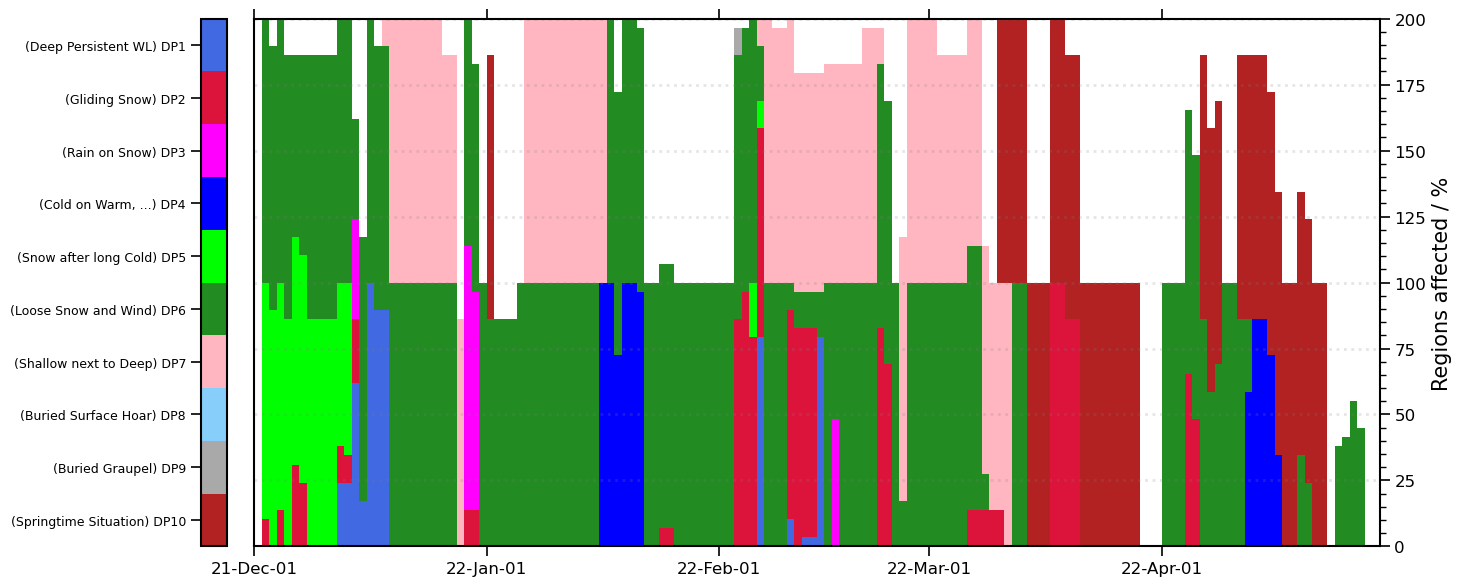

In [6]:
# - VISUALIZATION - #
%matplotlib inline
# %matplotlib widget
plt.style.use('latex_default.mplstyle')

# COLS_PATTERNS = ['lime','forestgreen','darkgray','magenta','royalblue','lightskyblue','blue','lightpink','crimson','firebrick']
COLS_PATTERNS = ['royalblue','crimson','magenta','blue','lime','forestgreen','lightpink','lightskyblue','darkgray','firebrick']
PATTERNS_NAMES = ['(Deep Persistent WL) DP1', '(Gliding Snow) DP2', '(Rain on Snow) DP3', '(Cold on Warm, ...) DP4', '(Snow after long Cold) DP5', '(Loose Snow and Wind) DP6', '(Shallow next to Deep) DP7', '(Buried Surface Hoar) DP8', '(Buried Graupel) DP9', '(Springtime Situation) DP10']
COL_INDEXES   = np.arange(0,len(PATTERNS_NAMES))
col_dict = dict(zip(COL_INDEXES,COLS_PATTERNS[::-1]))
cmap = ListedColormap([col_dict[x] for x in col_dict.keys()])

fig, ax = plt.subplots(1,1,figsize=(15,6))
w=df_danger_patterns.index[1]-df_danger_patterns.index[0]
for i in range(len(df_danger_patterns)):
    bar_plot = ax.bar(df_danger_patterns.index[i], df_danger_patterns.loc[df_danger_patterns.index[i]], bottom=df_danger_patterns_cum.loc[df_danger_patterns.index[i]], width=w, align='edge', color=COLS_PATTERNS)

# - COLORBAR (Norm, bins, formatter, ticks) ** lots of stuff to make colorbar look nice - #
n_bar = len(COLS_PATTERNS)
lulu = np.zeros((n_bar,n_bar))
for nn,k in enumerate(col_dict.keys()):
    lulu[nn, :] = k
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

norm = BoundaryNorm(norm_bins, n_bar, clip=True)
fmt = FuncFormatter(lambda x, pos: PATTERNS_NAMES[::-1][norm(x)])
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2

contf = ax.contourf(lulu,cmap=cmap,norm=norm,levels=norm_bins) # just for colorbar
cbar = fig.colorbar(contf, format=fmt, ticks=tickz,location='left', pad=0.02) # shrink=0.7, ax=[axes[1],axes[3], axes[5]]
cbar.ax.tick_params(labelsize=9)

# - AXES - # 
ax.set_xlim(df_danger_patterns.index[0],df_danger_patterns.index[-1])
# ax.set_ylim(0,100)

ax.grid(axis='x')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("Regions affected / %")

myLoc = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%y-%b-%d') # %Y-%b-%d
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(myLoc)
ax.yaxis.set_minor_locator(AutoMinorLocator())

# --- Save figure --- #
filename  = 'dangerPatterns-over-season'
out_dir   = "output"
directory = Path(out_dir)
directory.mkdir(parents=True, exist_ok=True)
fig.tight_layout()
fig.savefig(f'{out_dir}/{filename}.png', facecolor='w', edgecolor='w',
            format='png', dpi=300)

/var/folders/5n/r616r2rx3710m3kyf90_xwdr0000gn/T/ipykernel_47641/46880026.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(PATTERNS_NAMES[::-1])


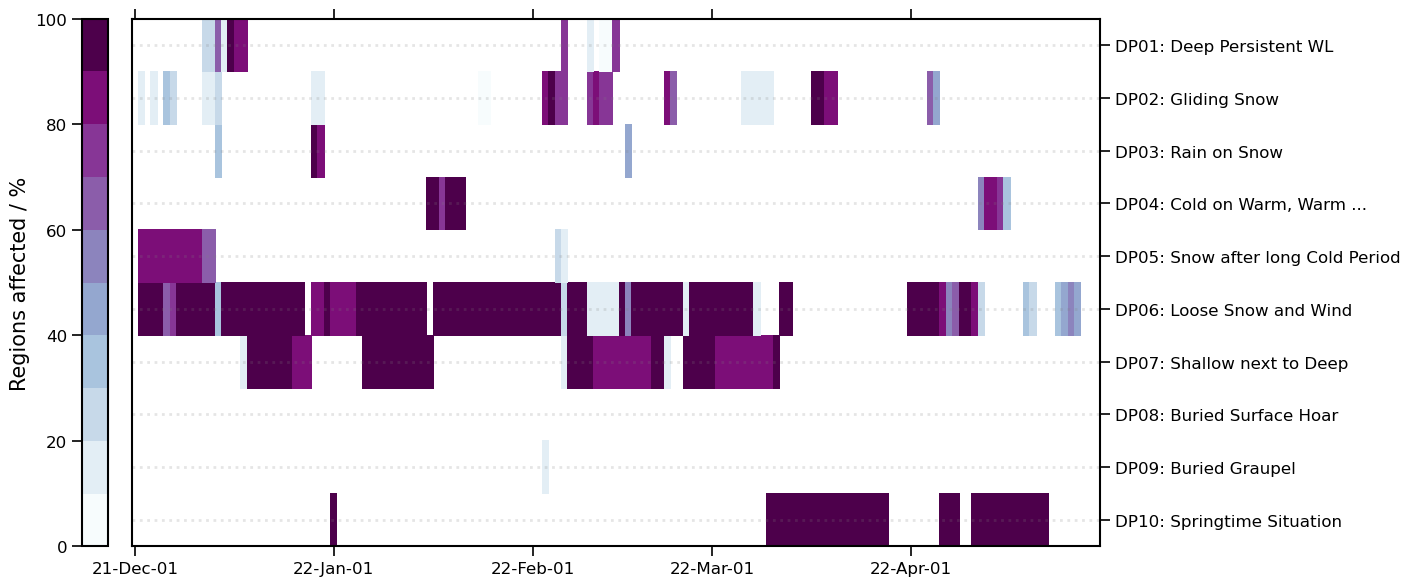

In [18]:
# - Alternative solution for DPs - #
data_temp = df_danger_patterns.T.to_numpy()
data = np.where(data_temp>1,data_temp,np.nan)
data = data[::-1,:]
PATTERNS_NAMES = ['DP01: Deep Persistent WL', 'DP02: Gliding Snow', 'DP03: Rain on Snow', 'DP04: Cold on Warm, Warm ...', 'DP05: Snow after long Cold Period', 'DP06: Loose Snow and Wind', 'DP07: Shallow next to Deep', 'DP08: Buried Surface Hoar', 'DP09: Buried Graupel', 'DP10: Springtime Situation']

# cmap = plt.get_cmap('YlOrBr')
# cmap = plt.get_cmap('gnuplot_r')
# cmap = plt.get_cmap('terrain_r')
# cmap = plt.get_cmap('plasma_r')
cmap = plt.get_cmap('BuPu')

bounds = np.linspace(0,100,11)
norm = BoundaryNorm(bounds,cmap.N)

fig, ax = plt.subplots(1,1,figsize=(15,6))
pcolor = ax.pcolor(df_danger_patterns.index, patterns, data, shading='auto', cmap=cmap, norm=norm)
cbar = fig.colorbar(pcolor, pad=0.02, location='left') # pad=0.02, shrink=0.67
# cbar = fig.colorbar(pcolor, location='top',fraction=0.05, shrink=1) # pad=0.02, shrink=0.67
cbar.set_label("Regions affected / %")

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.grid(axis='y')
myLoc = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%y-%b-%d') # %Y-%b-%d
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(myLoc)
ax.set_yticklabels(PATTERNS_NAMES[::-1])

# --- Save figure --- #
filename  = 'dangerPatterns-over-season-2'
out_dir   = "output"
directory = Path(out_dir)
directory.mkdir(parents=True, exist_ok=True)
fig.tight_layout()
fig.savefig(f'{out_dir}/{filename}.png', facecolor='w', edgecolor='w',
            format='png', dpi=300)

## 3. Euregio regions summary

- Boxplot of distribution from warning regions
- bar charts of how many warning regions concerned Tyrol,    
  Trento, South Tyrol, Tyrol and Trentino, Tyrol and South 
  Tyrol, South Tyrol and Trentino, or Tyrol, South Tyrol and
  Trentino?

In [8]:
import xml.etree.ElementTree as ET
import os
from pyAvaCore.avacore.avabulletins import Bulletins
from pyAvaCore.avacore import pyAvaCore
from IPython.display import clear_output

import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

# ------------------------------------ #
start_season = "2021-12-01" # as string with YYYY-MM-DD
end_season   = "2022-04-30" # as string with YYYY-MM-DD

regions_of_interest = ['AT-07','IT-32-BZ','IT-32-TN']  # Euregio_regions are possible, e. g. ['AT-07', 'IT-32-BZ']
# ------------------------------------ #

In [ ]:
local_dir = os.getcwd() + "/data/bulletins"

day_range = pd.date_range(start=start_season,end=end_season).to_pydatetime().tolist()
day_range = [d.date() for d in day_range]
df_avaProbs = pd.DataFrame(0, index=np.arange(len(avaProbs)), columns=day_range)

for file in os.listdir(local_dir):
    if "EUREGIO" in file:
        bulletins = Bulletins()
        with open(local_dir + '/' + file) as fp:
            # clear_output(wait=True)
            # print(file)
            if ".xml" in file:
                root = ET.parse(fp)
                bulletins.bulletins = pyAvaCore.parse_xml(root)
            if ".json" in file:
                data = json.load(fp)
                try:
                    bulletins.from_json(data)
                except:
                    print("Can't work with JSON file:", file)
        date = bulletins.main_date()
        if date < datetime.datetime.strptime(end_season, "%Y-%m-%d").date() and date > datetime.datetime.strptime(start_season, "%Y-%m-%d").date():
            no_regions = 0.
            ### print(no_regions)
            i=0
            for bulletin in bulletins.bulletins:
                ### print(bulletin.get_region_list())
                bulletin_no_regions = sum(check_regions_of_interest(x) for x in bulletin.get_region_list())
                no_regions += bulletin_no_regions
                ### print(i,no_regions)
                # if bulletin.avalancheProblems:

                i+=1
                
            # for avaProb in avaProbs:
            #     n = avaProbs.index(avaProb)
            #     df_avaProbs.loc[n, date] = 100 * df_avaProbs.loc[n, date] / no_regions
                # df_avaProbs.loc[n, date] = 100 * df_avaProbs.loc[n, date] / 58

In [ ]:
#loop create groups per single days - then creates an array with every
#BulletinId of this day. len of array correspond to the number of warning 
#regions of one day
numberofwarnregionen = []
BulletinIdList = []
for date in datelist:
    onedate = df_saison2021.groupby(['Date']).get_group(str(date)[0:10])
    BulletinIdperday = onedate.groupby(['BulletinId']).count()
    numberofwarnregionen.append(BulletinIdperday.shape[0])
    BulletinIdperday_modi = BulletinIdperday.reset_index()
    for ID in BulletinIdperday_modi['BulletinId']:
        BulletinIdList.append(ID)
    
   

#create new df with list from loop then save it   
df_save =  pd.DataFrame()    
df_save['Date'] = datelist    
df_save['number of warning regions per day'] = numberofwarnregionen 
df_save.to_csv(r'output\numberofwarningregions.csv')   


#%%
warntage = len(datelist)
warnregionentotalsum = df_save['number of warning regions per day'].sum()
warnregionendailymedian = df_save['number of warning regions per day'].median()

print('Summe der Warntage: ' + str(warntage))
print('Summe aller Warnregionen: ' + str(warnregionentotalsum))
print('Täglicher Median: ' + str(warnregionendailymedian))



#%% 

AT07 = 0
IT32TN = 0
IT32BZ = 0
IT32TN_BZ = 0
AT07_IT32BZ = 0
AT07_IT32TN = 0
AT07_IT32TN_BZ = 0

numberofwarnregionen2 = []
for date in datelist:
    onedate2 = df_saison2021.groupby(['Date']).get_group(str(date)[0:10])
    BulletinIdperday2 = onedate2.groupby(['BulletinId']).count()
    #creates list with ids of one single day
    numberofwarnregionen.append(BulletinIdperday2.shape[0])
    BulletinIdperday_modi = BulletinIdperday2.reset_index()
    BulletinIdList = []
    for ID in BulletinIdperday_modi['BulletinId']:
        BulletinIdList.append(ID)

    #makes Group for in single day and one single ID then drops duplicates of Regions
    for ID in BulletinIdList:  
        BulletinIdGroupperday = onedate2.groupby(['BulletinId']).get_group(str(ID))
        #BulletinIdGroupperday = onedate2.groupby(['BulletinId']).get_group('1fbf1de4-56db-41db-abff-1680b0665355')
        RegionsinId = BulletinIdGroupperday.drop_duplicates(subset=['Region'])
        listofregionperday = []
        for i in RegionsinId['Region']:
           listofregionperday.append(i)
               
        if len(listofregionperday) == 3:
            AT07_IT32TN_BZ +=1 
        
        elif len(listofregionperday) ==2:
            if 'IT-32-BZ' and 'IT-32-TN' in listofregionperday:
                IT32TN_BZ +=1
                
            elif 'AT-07' and 'IT-32-BZ' in listofregionperday:
                AT07_IT32BZ +=1
        
            elif 'AT-07' and 'IT-32-TN' in listofregionperday:
                AT07_IT32TN +=1   
            
        elif len(listofregionperday) ==1:
            if listofregionperday[0] == 'AT-07':
                AT07 +=1
        
            elif listofregionperday[0] == 'IT-32-TN':
                IT32TN +=1
        
            elif listofregionperday[0] == 'IT-32-BZ':
                IT32BZ +=1
            
             

 
IsItCorrect = AT07 + IT32TN + IT32BZ + AT07_IT32BZ + AT07_IT32TN + IT32TN_BZ + AT07_IT32TN_BZ
print('is it correct '  + str(IsItCorrect) + 'warning regions')

#%%plotting routine

#--------------first figure--------------
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
regions = ['AT07', 'IT32TN', 'IT32BZ', 'AT07_IT32BZ', 'AT07_IT32TN', 'IT32TN_BZ', 'AT07_IT32TN_BZ']
numberofregions = [AT07, IT32TN, IT32BZ, AT07_IT32BZ, AT07_IT32TN, IT32TN_BZ, AT07_IT32TN_BZ]
ax.bar(regions,numberofregions)
plt.title('Number of Warningregions by Region')
plt.show() 
plt.savefig(r'output\mimi.png')
#--------------second figure--------------
plt.figure(figsize=(3,4))
df_save.boxplot(column=['number of warning regions per day'], 
                grid='doted', fontsize=15)

#--------------third figure--------------
plt.figure(figsize=(7,4))
plt.plot(df_save['Date'], df_save['number of warning regions per day'])